In [1]:
# asume que los datos estan en ../data/<año>.csv.bz2
# fixme: poner el directorio de data que esté en el repo cuando pusheen los pibes

import seaborn as sns
import matplotlib.pyplot as plt

import fnmatch

import pandas as pd
import time
import os
import shutil
#sns.set(color_codes=True)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import numpy as np
import math

# load data
tmp_dir = "./tmp_csv/"
years = [str(year) for year in range(1994,2009)]
#years = [str(year) for year in range(1994,2005)]

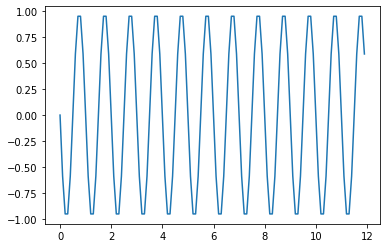

In [2]:
#para jugar con fases

time        = np.arange(0, 12, 0.1);
amplitude   = np.sin(2 * math.pi / 1* time + math.pi)
plt.plot(time, amplitude)
plt.show()

In [3]:
def nrmse(pred,y):
    return math.sqrt(mean_squared_error(pred, y)) / (y.max()-y.min())

max_grade = 0
phases = [i*math.pi/2 for i in range(4)]
monthly_freqs =  [3, 4, 6, 12]
# semanas, meses, bimestres, trimestres, cuatrimestres, semestres, años
daily_freqs =  [7] + [355/i for i in [12, 6, 4, 3, 2, 1]] 

class lsqPredictor:
    def __init__(self, phases, freqs, max_grade):
        self.phases = phases
        self.freqs = freqs
        self.max_grade = max_grade
    
    def trig_vals(self, t):
        return  [math.sin(2 * math.pi / f * t + p) for f in self.freqs for p in self.phases]

    def get_x_vals(self, x):
        x_vals = []
        for i in range(len(x)):
            row = np.array([i**p for p in range(self.max_grade+1)] + self.trig_vals(i), dtype='float')
            x_vals.append(row)
        return x_vals
    
    def print_coefs(self):
        c = 0
        for i in range(self.max_grade+1):
            print("Coef de x^{}:\n{}".format(i, self.coefs[c]))
            c += 1
        for i in self.freqs:
            for j in self.phases:
                print("Coef de sinusoide con frecuencia {} y fase {}:\n{}".format(i, j, self.coefs[c]))
                c += 1
                
    def fit(self, train_set):
        arrays = self.get_x_vals(train_set)
        A = np.stack(arrays)
        self.coefs = np.linalg.solve(A.T@A, A.T@train_set)
    
    def pred(self, pred_set):
        arrays = self.get_x_vals(pred_set)
        full_A = np.stack(arrays)        
        return full_A@self.coefs 

In [4]:
def plot_df(df1, df2, train_limit_axis, unit_str, sparse_plot=True):
    plt.figure(figsize=(16,5))
    plt.xlabel('Predicción para el i-ésimo {}'.format(unit_str))
    plt.ylabel('Delay de arribo (mins)')
    
    if sparse_plot:
        df2 = df2[df2.index % 20 == 0] 
        df1 = df1[df1.index % 20 == 0] 
    
    ax1 = df1.dl_pred.plot(color='orange', grid=True, label='pred delay', legend="pred")
    df2.ArrDelay.plot(color='blue', grid=True, secondary_y=False, label='real delay', ax=ax1, legend="delay")

    xticks = ax1.xaxis.get_major_ticks()
    plt.axvline(x=train_limit_axis, color="green")
    plt.show()

In [11]:
#Validación cruzada y gráficos
def cross_val_delays(filename, freqs, unit_name, sparse_plot=False, n=4):
    for trim in ["full", "cut"]:
        print("\n\n------Trim de outliers: {}------------------------------------".format(trim))
        df = pd.read_csv(tmp_dir+"{}/{}.csv".format(filename, trim))
        df['date'] = pd.to_datetime(df['date'], errors='coerce')
        df.sort_values(by="date")

        tscv = TimeSeriesSplit(n_splits=n)
        df_full = pd.read_csv(tmp_dir+"{}/full.csv".format(filename))
        df_full['date'] = pd.to_datetime(df_full['date'], errors='coerce')
        
        #si recortamos alguna fecha por outliers la sacamos de df_full tambien para comparar
        if trim == "cut":
            df_full = df_full.loc[df_full["date"].isin(df.date)]
            
        for train_index, test_index in tscv.split(df):
            delays_train, delays_test = df.iloc[train_index]["ArrDelay"], df.iloc[test_index]["ArrDelay"]
            lpr = lsqPredictor(phases, freqs, max_grade)
            lpr.fit(delays_train)
            
            #descomentar para ver coeficientes -----------
            #lpr.print_coefs()
            train_test_delays = df["ArrDelay"]

            df2 = df
            day_train_limit = df2.iloc[len(delays_train)]["date"]

            print("Entrena hasta la fecha: {}".format(day_train_limit))
            df2["dl_pred"] = lpr.pred(train_test_delays) 
            plot_df(df2, df_full, len(delays_train), unit_name, sparse_plot)
            
            error = nrmse(
                df2.loc[df["date"].dt.date > day_train_limit].dl_pred, 
                df_full.loc[df_full["date"].dt.date > day_train_limit].ArrDelay
            )

            print(error)

## Procesar datos

In [ ]:
#crear directorio con data de delays agrupada por retraso 

# frequency = 'D' (diario) o 'M' (mensual)
def create_grouped_files(subdir, years, frequency):
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

    if not os.path.exists(tmp_dir + subdir):
        os.makedirs(tmp_dir + subdir)
    else: 
        return
    
    df_cut = pd.DataFrame(columns=["date", "ArrDelay"]).set_index("date")
    df_full = pd.DataFrame(columns=["date", "ArrDelay"]).set_index("date")
    for year in years:
        if not os.path.exists(tmp_dir+subdir+year+".csv"):
            print("Leyendo csv: {}".format(year))
            df = pd.read_csv("../data/"+year+".csv.bz2", compression="bz2", \
                             usecols=["Month", "Year", "DayofMonth", "DayOfWeek", "ArrDelay"], \
                             encoding="ISO 8859-1")    
        
            #formato mas feliz para fechas
            dates = pd.to_datetime(df.Year*10000+df.Month*100+df.DayofMonth, format='%Y%m%d')
            df["date"] = dates
            
            #acumulamos en full antes de recortar outliers
            df = df[["date", "ArrDelay"]]
            
            dg = df.groupby(pd.Grouper(key='date', freq=frequency)).mean()
            df_full = pd.concat([df_full, dg], sort=False)
            
            #sacamos outliers, nos quedamos con la mitad de los delays por bucket
            low = 0.1
            high = 0.9
            qiles = df.groupby(pd.Grouper(key='date', freq=frequency))["ArrDelay"].quantile([low, high]).unstack(level=1)
            mask =  (qiles.loc[df.date, low] < df.ArrDelay.values) & \
                    (df.ArrDelay.values < qiles.loc[df.date, high])
            df = df.loc[mask.values]

            #agrupamos
            df = df.groupby(by=df['date'].dt.date).mean()
            
            df.to_csv(tmp_dir+subdir+year+".csv")
            df_cut = pd.concat([df_cut, df], sort=False)
            del df 
            
    df_cut.to_csv(tmp_dir+subdir+"cut"+".csv")
    df_full.to_csv(tmp_dir+subdir+"full"+".csv")

create_grouped_files("daily/", years, 'D')
print("Listo ./tmp_csv/daily/")
create_grouped_files("monthly/", years, 'M')
print("Listo ./tmp_csv/monthly/")

In [ ]:
for filename in sorted(os.listdir(tmp_dir+"monthly/")):
    if filename.endswith(".csv") and filename not in ["cut.csv", "full.csv"]: 
        print(filename)
        df = pd.read_csv(tmp_dir+"monthly/"+filename)
        fig, ax = plt.subplots(figsize=(16,4))
        sns.lineplot(x=df.date, y=df.ArrDelay, linestyle='-')
        plt.xticks(plt.xticks()[0], df.date, rotation=90)
        plt.tight_layout()
        xticks = ax.xaxis.get_major_ticks()
        for i in range(len(xticks)):
            """
            if i%1 != 0:
                xticks[i].set_visible(True)            
            """
            if i%int((len(xticks))/4) == 0:    
                plt.axvline(x=i, color="orange")
            if i%int((len(xticks))/3) == 0:    
                plt.axvline(x=i, color="green")
        fig.autofmt_xdate()
        plt.show()
        
#Trimestres en verde, cuatrimestres en naranja

            date   ArrDelay
0     1994-01-01   0.294359
1     1994-01-02   5.543427
2     1994-01-03   8.508602
3     1994-01-04   8.007037
4     1994-01-05   9.983885
...          ...        ...
5473  2008-12-27  25.030015
5474  2008-12-28   4.857496
5475  2008-12-29  -2.538072
5476  2008-12-30   0.703750
5477  2008-12-31   2.641123

[5478 rows x 2 columns]


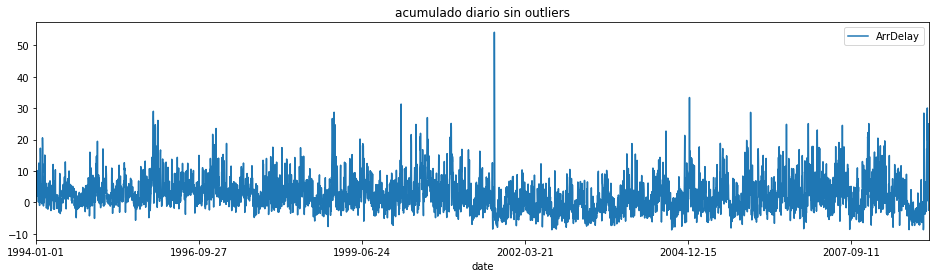

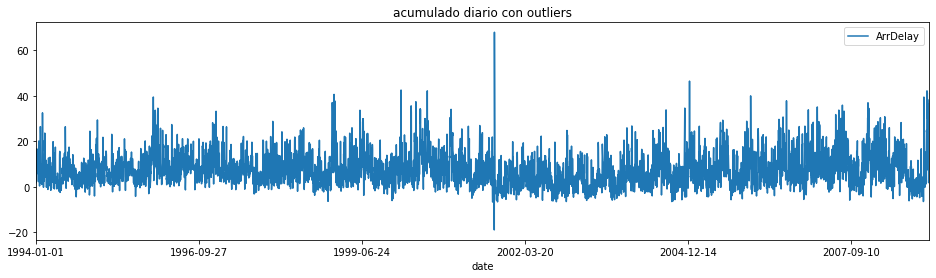

In [2]:
df_daily_cut = pd.read_csv(tmp_dir+"daily/cut.csv")
print(df_daily_cut)
df_daily_cut.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado diario sin outliers")

df_daily_full = pd.read_csv(tmp_dir+"daily/full.csv")
df_daily_full.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado diario con outliers")

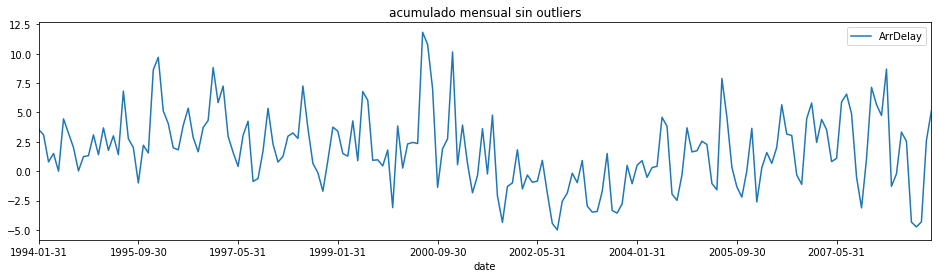

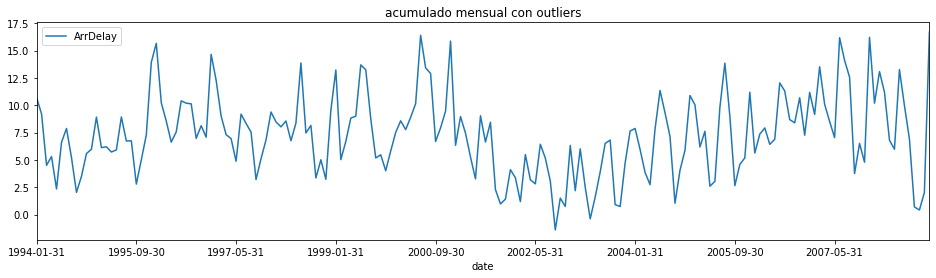

In [3]:
df_monthly_cut = pd.read_csv(tmp_dir+"monthly/cut.csv")
df_monthly_cut.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado mensual sin outliers")

df_monthly_full = pd.read_csv(tmp_dir+"monthly/full.csv")
df_monthly_full.plot(x="date", y="ArrDelay", linestyle='-', figsize=(16,4), title = "acumulado mensual con outliers")

# Análisis de delays
## Diario

In [123]:
del df

NameError: name 'df' is not defined



------Trim de outliers: full------------------------------------
Entrena hasta la fecha: 1997-01-04 00:00:00


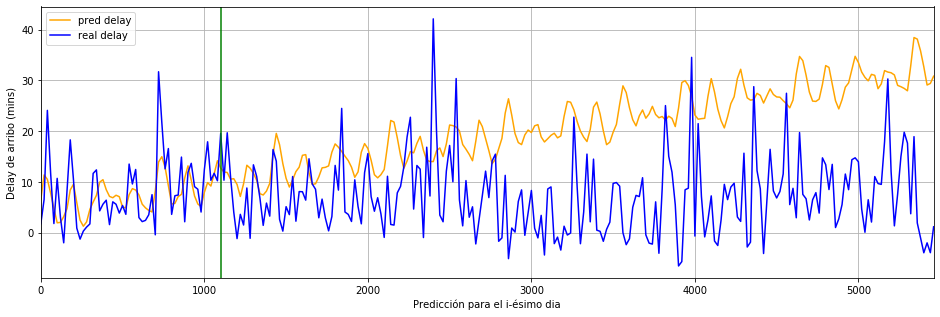

0.20212659895946364
Entrena hasta la fecha: 2000-01-04 00:00:00


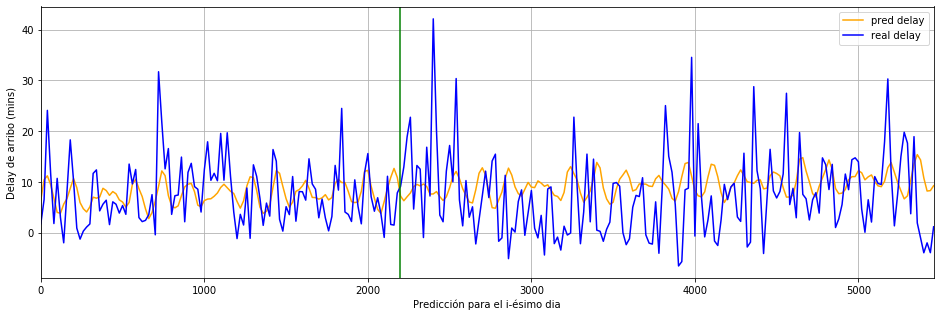

0.0995023735330745
Entrena hasta la fecha: 2003-01-03 00:00:00


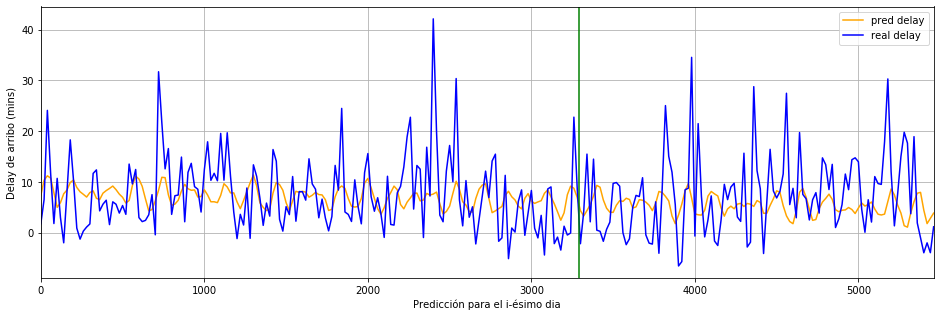

0.1599711673171604
Entrena hasta la fecha: 2006-01-02 00:00:00


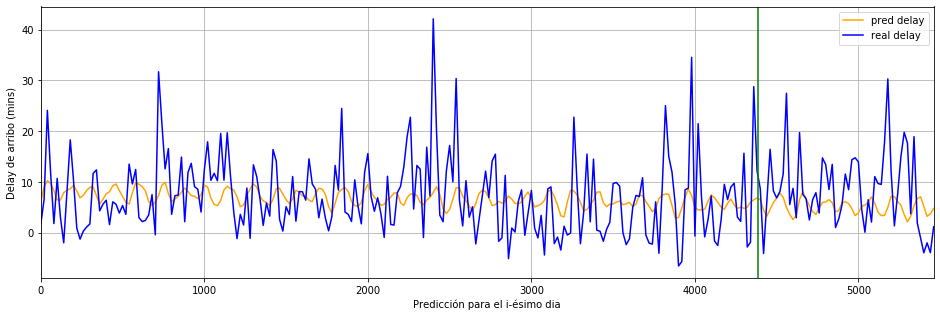

0.1883282818968642


------Trim de outliers: cut------------------------------------
Entrena hasta la fecha: 1997-01-03 00:00:00


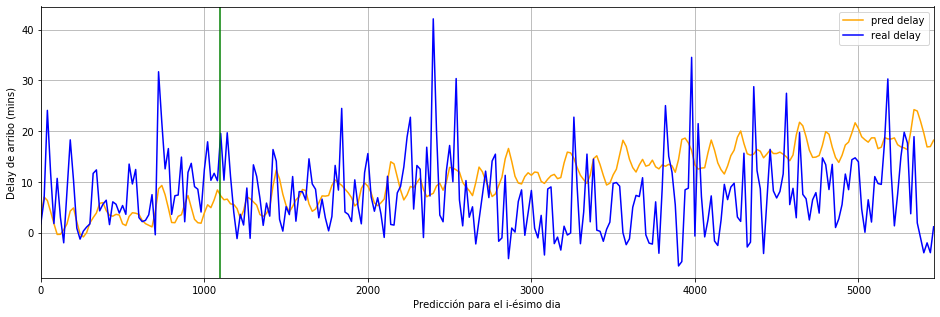

0.13768415065126563
Entrena hasta la fecha: 2000-01-03 00:00:00


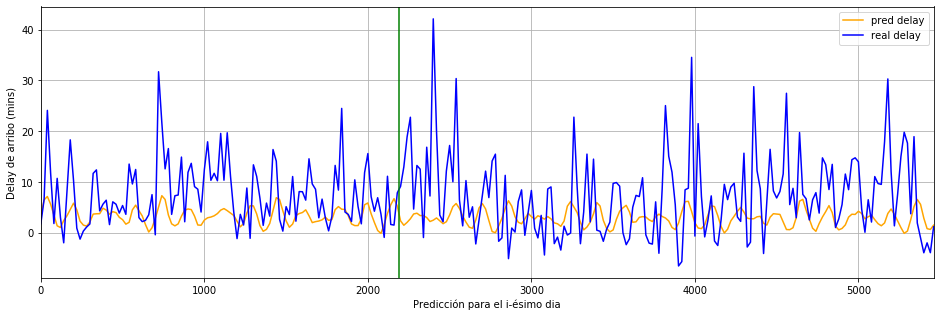

0.12192288639498623
Entrena hasta la fecha: 2003-01-03 00:00:00


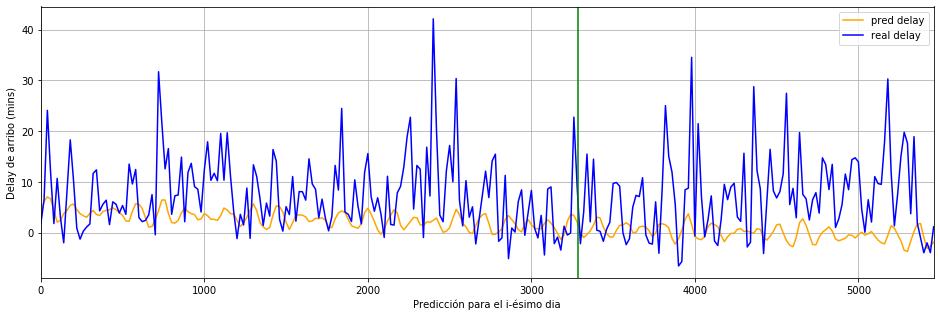

0.20810722411991597
Entrena hasta la fecha: 2006-01-02 00:00:00


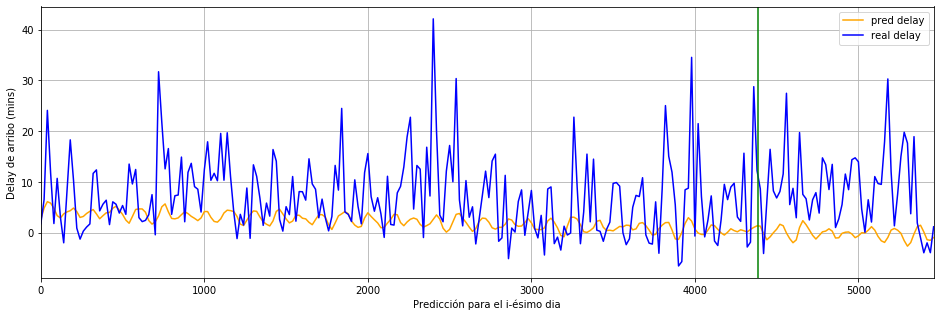

0.25324229995093306


In [12]:
max_grade = 1

cross_val_delays("daily", daily_freqs, "dia", True, 4)

## Mensual

In [56]:
del df



------Trim de outliers: full------------------------------------
Entrena hasta la fecha: 1997-01-31 00:00:00


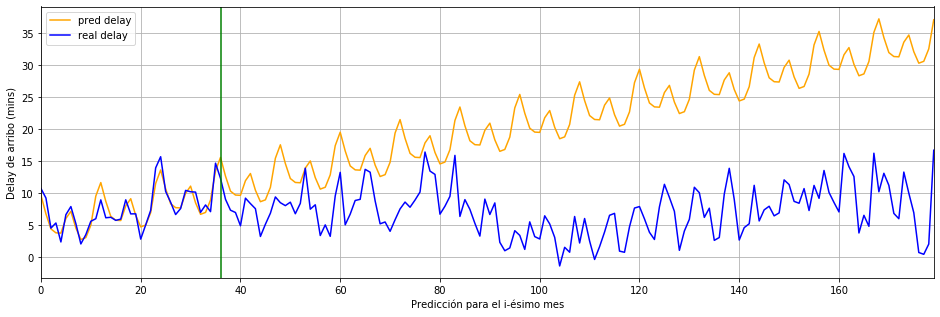

0.930145256934777
Entrena hasta la fecha: 2000-01-31 00:00:00


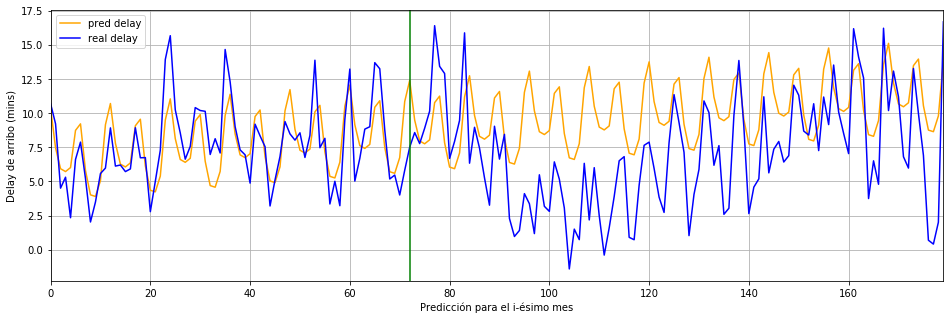

0.25928993939594575
Entrena hasta la fecha: 2003-01-31 00:00:00


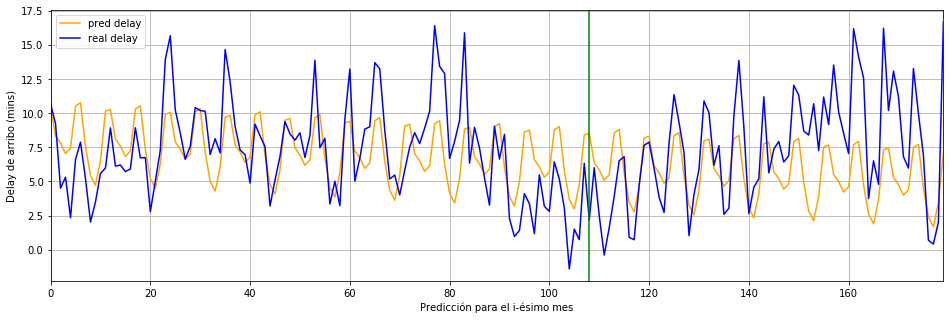

0.2275390738590648
Entrena hasta la fecha: 2006-01-31 00:00:00


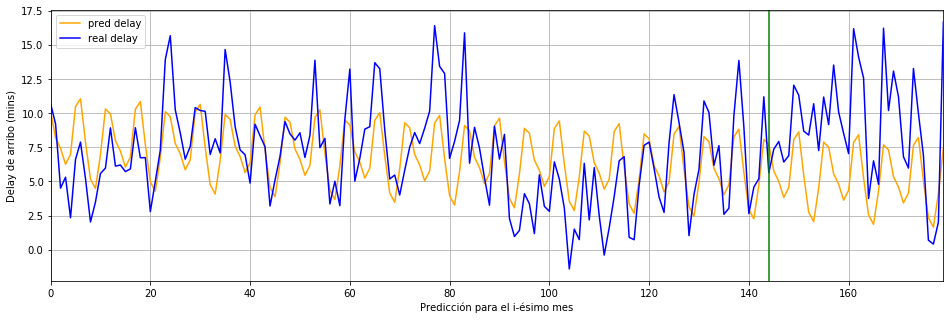

0.29687725111942875


------Trim de outliers: cut------------------------------------
Entrena hasta la fecha: 1997-01-31 00:00:00


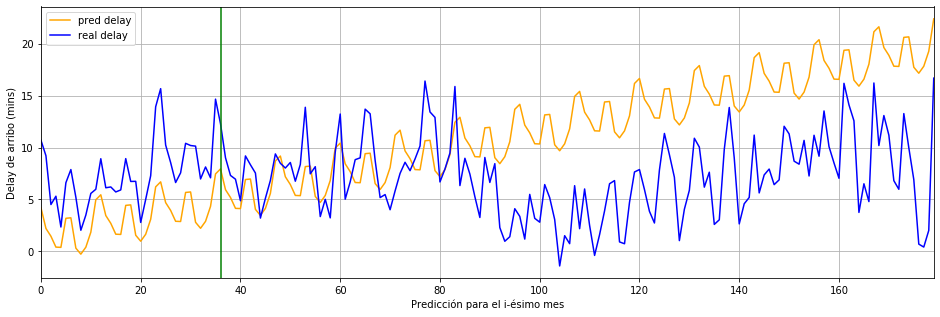

0.4119811611933988
Entrena hasta la fecha: 2000-01-31 00:00:00


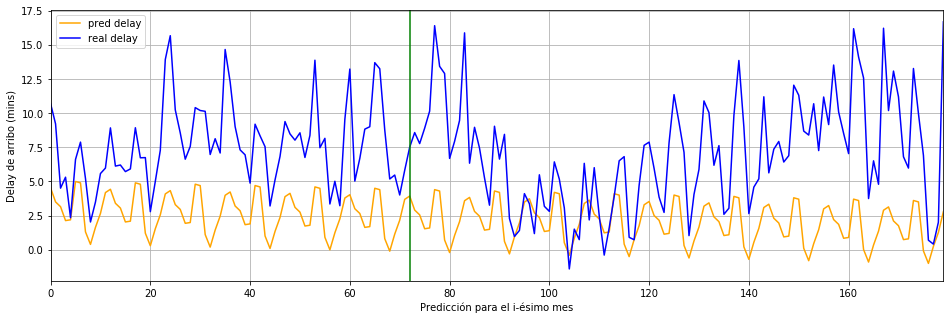

0.3473009013823147
Entrena hasta la fecha: 2003-01-31 00:00:00


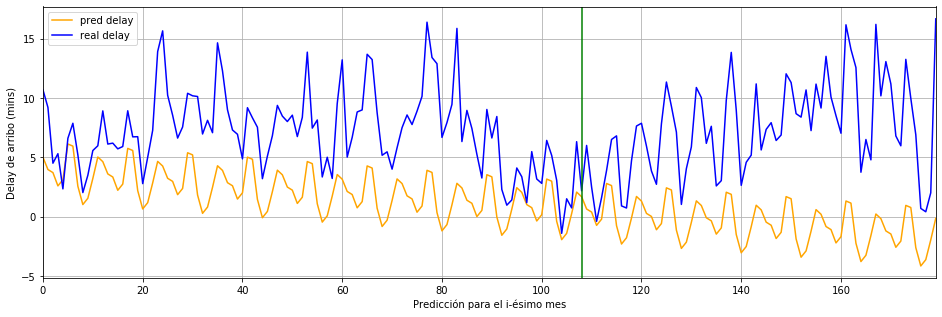

0.5186189866497644
Entrena hasta la fecha: 2006-01-31 00:00:00


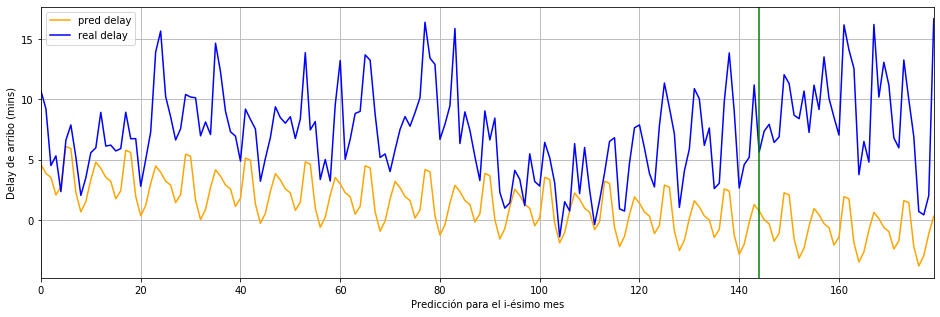

0.6352885897792532


In [7]:
max_grade = 1

cross_val_delays("monthly", monthly_freqs, "mes")

## BORRAR ARCHIVOS

In [ ]:
#borrar aux de años
for filename in os.listdir(tmp_dir):
    if fnmatch.fnmatch(filename, '*.csv') and filename != "merged.csv":
        os.remove(tmp_dir+filename)

In [ ]:
#borrar merged
os.remove(tmp_dir+"merged.csv")

In [ ]:
#borrar tmp
shutil.rmtree(tmp_dir)